In [1]:
# default_exp geometry.rasterized_geometry

# Create rasterized geometry

The purpose of this module is to take an abstract geometry and realize it in format of a rasterized image

> API details.

In [2]:
#hide
from nbdev.showdoc import *
import matplotlib.pyplot as plt

In [3]:
#hide
import os, sys

sys.path.append(os.path.join(os.getcwd(), '..'))

In [4]:
#export
from shapely.geometry import Point, box, Polygon, MultiPoint, MultiPolygon, LineString, MultiLineString
from geocube.api.core import make_geocube
import geopandas as gpd
import numpy as np

from accelerate_simulations.geometry import AbstractGeometry

In [7]:
#hide
box_size = (200, 200)
circle_radius_range = (20, 50)
gap = 10
circle_density = 0.90

abstract_geometry = AbstractGeometry(
    circle_density, 
    circle_radius_range, 
    box_size, 
    gap, 
    seed=1)

[100.0, 100.0, 200, 200]


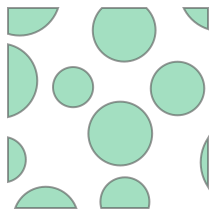

In [8]:
circles, box_coord_dim = abstract_geometry.get_geom_info()
print(box_coord_dim)
circles

In [9]:
#export
element_to_tag = {
    "circles": 1,
    "box_wo_circles": 2,
    "circles_boundaries": 3
}

In [30]:
#export
class GeometryRasterizer:
    def __init__(self, resolution):
        self.resolution = resolution

    def __call__(self, abstract_geometry: AbstractGeometry):
        circles, box_coord_dim = abstract_geometry.get_geom_info()

        grid_size = self._calculate_grid_size(box_coord_dim)

        boxx = self._make_box(circles, box_coord_dim)
        
        vector_data = self._make_geopandas_dataframe(circles, boxx)

        raster_array = make_geocube(
            vector_data=vector_data, 
            resolution=grid_size, 
            fill=0) 

        x = np.array(raster_array.x)
        y = np.array(raster_array.y)
        raster_image = np.array(raster_array.tags)

        return x, y, raster_image

    def _calculate_grid_size(self, box_coord_dim):
        x, y, dx, dy = box_coord_dim
        grid_size = (dx/self.resolution[0], dy/self.resolution[1])
        return grid_size

    def _make_geopandas_dataframe(self, circles, boxx):
        tags = list(element_to_tag.values())
        geometries = [circles, boxx, circles.boundary]

        g = gpd.GeoDataFrame(
            {"tags": tags},
            geometry=geometries
        )
        return g

    def _make_box(self, circles, box_coord_dim):
        x, y, dx, dy = box_coord_dim
        boxx = box(x, y, x+dx, y+dy)
        return boxx.difference(circles)

In [31]:
rasterize = GeometryRasterizer(resolution=(200, 200))
x, y, raster_image = rasterize(abstract_geometry)


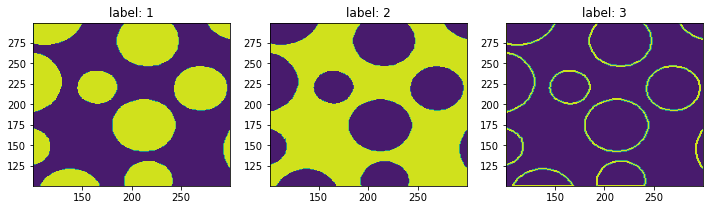

In [32]:
#hide
labels = [1, 2, 3]

fig, axs = plt.subplots(1, len(labels), figsize=(12, 3))
for idx, label in enumerate(labels):
    im = axs[idx].contourf(x, y, raster_image==label)
    axs[idx].set_title("label: " + str(label))

In [33]:
raster_image.shape

(200, 200)